# Install

In [1]:
# Libraries you might not have
# !python3 -m pip install --upgrade nbconvert 
# !python3 -m pip install --upgrade nbstripout 
# !python3 -m pip install tomotopy
# !python3 -m pip install sklearn

# Imports

In [2]:
import nltk
# Things to install from nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/dylfox21/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dylfox21/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [316]:
%load_ext autoreload
%autoreload 2

import tomotopy as tp
from itertools import chain
import tqdm
import pandas as pd
import numpy as np
from collections import defaultdict
import sklearn.preprocessing

import dataloader
import bow
import slda
import post_classifier
import aggregate
import user_classifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Process Train Data

In [5]:
# Uncomment below to process data if you have not already

POSTPATH = './Data/crowd/train/shared_task_posts.csv'
LABELPATH = './Data/crowd/train/crowd_train.csv'
USERPATH = './Data/crowd/train/task_C_train.posts.csv'

users = dataloader.load_user_subset_from_train(USERPATH, subset = 1000)
    
user_to_post, post_to_words, post_to_metadata = dataloader.load_posts(POSTPATH, user_subset = users, append_title = True)
post_to_label = dataloader.load_classification(LABELPATH, user_to_post, post_to_words, post_to_metadata, user_subset = users)
filtered_data, sw_posts, sw_timestamps = dataloader.filter_posts(post_to_label, post_to_metadata, filter_images=True)
print(len(filtered_data))
filtered_data = dataloader.filter_near_SW(filtered_data,post_to_metadata, sw_timestamps)
print(len(filtered_data))

filtered_data = dataloader.filter_stopwords(filtered_data)
sw_posts = dataloader.filter_stopwords(sw_posts)

 24%|██▍       | 498148/2038753 [00:00<00:00, 2486239.66it/s]

Flagging empty posts


  0%|          | 4330/2038753 [00:00<00:46, 43290.44it/s]

Appending Titles


  0%|          | 6908/2038753 [00:00<00:29, 69077.43it/s]

Filtering subset...


  0%|          | 1/57015 [00:00<1:44:54,  9.06it/s]

Tokenizing sentences...


 11%|█         | 6206/57015 [00:00<00:00, 62030.78it/s]

Normalizing...


  1%|          | 547/57015 [00:00<00:20, 2766.20it/s]

Tokenizing sentences into words...


100%|██████████| 57015/57015 [00:21<00:00, 2646.33it/s]


993


100%|██████████| 22454/22454 [00:00<00:00, 525974.57it/s]

22454
Filtering posts far away from SW posts...
9326


In [6]:
FOLDERPATH = './Processing/crowd_processed/'
dataloader.save_to_folder(FOLDERPATH, user_to_post, post_to_metadata, filtered_data, sw_posts, sw_timestamps)

# Load Process Train Data

In [7]:
FOLDERPATH = './Processing/crowd_processed/'
user_to_post, post_to_metadata, filtered_data, sw_posts, sw_timestamps = dataloader.load_from_folder(FOLDERPATH)

In [8]:
print(len([filtered_data[key] for key in filtered_data.keys() if filtered_data[key][2] == 'a']))
print(len([filtered_data[key] for key in filtered_data.keys() if filtered_data[key][2] == 'b']))
print(len([filtered_data[key] for key in filtered_data.keys() if filtered_data[key][2] == 'c']))
print(len([filtered_data[key] for key in filtered_data.keys() if filtered_data[key][2] == 'd']))
print(len(filtered_data))

258
138
342
1126
9326


# SLDA Model: Train

## Train Topic Model

In [9]:
model = slda.train_slda_model_from_data(filtered_data, topics=40)

100%|██████████| 9326/9326 [00:00<00:00, 50429.22it/s]


Beginning sLDA training...
Iteration: 0	Log-likelihood: -9.89359790412948
Iteration: 100	Log-likelihood: -9.007042553956603
Iteration: 200	Log-likelihood: -8.884777234083176
Iteration: 300	Log-likelihood: -8.829163488479255
Iteration: 400	Log-likelihood: -8.801821420841804
Iteration: 500	Log-likelihood: -8.777414636170192
Iteration: 600	Log-likelihood: -8.76721096351745
Iteration: 700	Log-likelihood: -8.760612140958017
Iteration: 800	Log-likelihood: -8.760580244242764
Iteration: 900	Log-likelihood: -8.75709510482071
Finished Training


## Topic Model Outputs

In [10]:
slda_coefficients = model.get_regression_coef(0)
data = []
for k in range(model.k):
    top_words = model.get_topic_words(k, top_n=40)
    words = [word for (word, float) in top_words]
    words = ", ".join(words)
    data.append([words, slda_coefficients[k]])
    
indices = np.array(slda_coefficients).argsort()
data = np.array(data)
data = data[indices]

pd.DataFrame(data, columns=["Topic", "Suicidality Coefficient"])

,Topic,Suicidality Coefficient
0,"url, us, min, survey, gt95, person, short, stu...",-4.768319129943848
1,"phone, screen, anyone, using, app, tried, prob...",-3.966301441192627
2,"im, get, going, looking, area, night, go, live...",-3.879598379135132
3,"english, language, german, word, swedish, nati...",-3.8670272827148438
4,"would, person, one, time, think, like, could, ...",-3.819622039794922
5,"person, im, u, gay, writing, known, tell, ship...",-3.759852170944214
6,"person, keys, w, h, url, price, ft, bo, blue, ...",-3.5882997512817383
7,"person, vs, team, persons, 2, round, 1, 3, sea...",-3.5339274406433105
8,"person, ps4, psn, gt, add, lvl, vog, looking, ...",-3.377411365509033
9,"person, music, song, video, show, play, watch,...",-3.343665838241577


In [11]:
# Uncomment to print example of overly negative topic
print(data[np.shape(data)[0]-1][0])

im, dont, like, know, get, want, really, feel, ive, people, cant, think, one, even, time, going, much, life, never, good, go, way, things, someone, always, make, need, love, say, doesnt, friends, still, thing, right, anything, ill, ever, tell, every, something


## sLDA Features: Train

In [305]:
vector_train = slda.get_topic_vecs(model, filtered_data)

  0%|          | 4/9326 [00:00<04:46, 32.52it/s]

Getting topic distributions...


100%|██████████| 9326/9326 [04:12<00:00, 36.89it/s]


In [306]:
#Uncomment to print example feature vector
print(vector_train['hw4uh'][0])

[0.00021011919307056814, 0.0002706496452447027, 0.0009008516208268702, 0.0006931030075065792, 0.12152151018381119, 0.0004159406526014209, 0.0004151506582275033, 0.0006476377020590007, 0.0008511901833117008, 0.03462923318147659, 0.06633228063583374, 0.0010116415796801448, 0.05008717253804207, 0.00040414181421510875, 0.00018693057063501328, 0.00018428926705382764, 0.00047738777357153594, 0.3977835178375244, 0.05093613266944885, 0.000411752873333171, 0.002747786697000265, 0.00032178827677853405, 0.23795880377292633, 0.0012312782928347588, 0.00041770789539441466, 0.0008525617304258049, 0.0011247692164033651, 0.00025776622351258993, 0.0001402874186169356, 0.00019230270117986947, 0.0007692993385717273, 0.0001928988640429452, 0.00012238768977113068, 0.0008457700605504215, 0.017356302589178085, 0.00044697854900732636, 0.005476377438753843, 0.0002934301446657628, 0.0004624654247891158, 0.00041843383223749697]


# BOW

In [307]:
word2index,index2word = bow.generate_vocabulary(filtered_data)
pca_model, vector_train_bow = bow.get_PCA_vectors_from_post_set(filtered_data, word2index)

100%|██████████| 9326/9326 [01:55<00:00, 80.86it/s]


# Post Classifier: Train

## Post Classifier: Train

In [335]:
def minmax_norm(arr):
    
    return (arr - np.min(arr))/(np.max(arr) -np.min(arr))

In [327]:
#USE JUST SLDA
X_train = np.array([ vector_train[key][0] for key in vector_train.keys()])
y_train = np.array([ vector_train[key][1] for key in vector_train.keys()])
y_train = y_train.reshape(np.shape(y_train)[0])

In [328]:
#USE JUST BOW
X_train = np.array([ vector_train_bow[key][0] for key in vector_train_bow.keys()])
y_train = np.array([ vector_train_bow[key][1] for key in vector_train_bow.keys()])
y_train = y_train.reshape(np.shape(y_train)[0])


In [329]:
#USE SLDA + BOW
X_train = np.array([ np.concatenate([minmax_norm(vector_train[key][0]),minmax_norm(vector_train_bow[key][0])]) for key in vector_train.keys()])
y_train = np.array([ vector_train[key][1] for key in vector_train.keys()])

y_train = y_train.reshape(np.shape(y_train)[0])

In [330]:
print(np.shape(X_train))
print(np.shape(y_train))

(9326, 80)
(9326,)


### Logistic Regression

In [16]:
#UNCOMMENT TO RUN GRID SEARCH CV
#p_clf = post_classifier.PostClassification("LogReg")
#param_dict = {'C':[0.2,0.5,0.7,1,1.5,2,5]}
#p_clf.train_grid_search_CV(X_train, y_train, param_dict, groups=5)

#RUN WITH OPTIMAL PARAMETERS
p_clf = post_classifier.PostClassification("LogReg")
p_clf.train(X_train, y_train)


### Linear SVM

In [ ]:
#UNCOMMENT TO RUN GRID SEARCH CV
#p_clf = post_classifier.PostClassification("LinearSVM")
#param_dict = {'C':[0.2,0.5,1,2]}
#p_clf.train_grid_search_CV(X_train, y_train, param_dict, groups=5)

p_clf = post_classifier.PostClassification("LinearSVM")
p_clf.train(X_train, y_train)

### RBF SVM

In [331]:
#UNCOMMENT TO RUN GRID SEARCH CV
#p_clf = post_classifier.PostClassification("RbfSVM")
#param_dict = {'C':[0.5,1,2,5]}
#p_clf.train_grid_search_CV(X_train, y_train, param_dict, groups=5)

p_clf = post_classifier.PostClassification("RbfSVM")
p_clf.train(X_train, y_train)

### AdaBoost

In [154]:
p_clf = post_classifier.PostClassification("AdaBoost")
p_clf.train(X_train, y_train)

### Random Forest

In [131]:
p_clf = post_classifier.PostClassification("RandomForest")
p_clf.train(X_train, y_train)

### Multi-layer Perceptron

In [175]:
#UNCOMMENT TO RUN GRID SEARCH CV
#p_clf = post_classifier.PostClassification("MLP")
#param_dict = {'hidden_layer_sizes':[(64,64),(64,64,64),(32,32), (32,32,32)], 'learning_rate': ('constant', 'adaptive')}
#p_clf.train_grid_search_CV(X_train, y_train, param_dict, groups=5)

p_clf = post_classifier.PostClassification("MLP")
p_clf.train(X_train, y_train)

Iteration 1, loss = 0.46964210
Iteration 2, loss = 0.35091662
Iteration 3, loss = 0.34005469
Iteration 4, loss = 0.33419748
Iteration 5, loss = 0.32943707
Iteration 6, loss = 0.32526528
Iteration 7, loss = 0.32110608
Iteration 8, loss = 0.31824231
Iteration 9, loss = 0.31452631
Iteration 10, loss = 0.31219934
Iteration 11, loss = 0.30729025
Iteration 12, loss = 0.30477481
Iteration 13, loss = 0.29942484
Iteration 14, loss = 0.29564128
Iteration 15, loss = 0.29164086
Iteration 16, loss = 0.28774486
Iteration 17, loss = 0.28302086
Iteration 18, loss = 0.27658662
Iteration 19, loss = 0.27176641
Iteration 20, loss = 0.26583517
Iteration 21, loss = 0.26321070
Iteration 22, loss = 0.25756615
Iteration 23, loss = 0.25019726
Iteration 24, loss = 0.24730020
Iteration 25, loss = 0.24089857
Iteration 26, loss = 0.23776378
Iteration 27, loss = 0.23006675
Iteration 28, loss = 0.23044277
Iteration 29, loss = 0.22072927
Iteration 30, loss = 0.21657411
Iteration 31, loss = 0.21528094
Iteration 32, los

## Predict Post Classifier: Train

In [332]:
y_pred_train = p_clf.test(X_train)

In [333]:
p_clf.get_metrics(y_train, y_pred_train)

{'accuracy': 0.7401887197083423,
 'precision': 0.29510268562401265,
 'recall': 0.8294849023090586,
 'f1': 0.4353297599627127}

In [334]:
print(sum(y_pred_train))
print(sum(y_train))

3165
1126


# User Classfier: Train

## Aggregate: Train

In [336]:
# change y from a, b, c, d, control to -, 1
user_to_y_train = defaultdict(int)
for data in tqdm.tqdm(filtered_data.keys()):
    user_to_y_train[filtered_data[data][0]] = (1 if filtered_data[data][2] == 'd' else 0)

100%|██████████| 9326/9326 [00:00<00:00, 1652768.80it/s]


In [337]:
post_to_uypred_train = defaultdict(list)

for i, post_id in enumerate(vector_train.keys()):
    user_id = filtered_data[post_id][0]
    post_to_uypred_train[post_id] = [user_id, y_pred_train[i]]

In [338]:
user_to_post_label_train = aggregate.aggregate_posts(FOLDERPATH, post_to_uypred_train)

Saved aggreagation of user to post labels...


## Argmax: Train

In [339]:
u_clf_train = user_classifier.UserClassification(user_to_post_label_train)
user_to_ypred_train = u_clf_train.argmax()

In [340]:
user_y_train = []
user_y_pred_train = []
for user_id in user_to_ypred_train:
    user_y_train.append(user_to_y_train[user_id])
    user_y_pred_train.append(user_to_ypred_train[user_id])

In [341]:
u_clf_train.get_metrics(user_y_train, user_y_pred_train)

{'accuracy': 0.752112676056338,
 'precision': 0.4280442804428044,
 'recall': 0.8467153284671532,
 'f1': 0.5686274509803921}

# Process Data: Test

In [283]:
POSTPATH2 = './Data/crowd/test/shared_task_posts_test.csv'
LABELPATH2 = './Data/crowd/test/crowd_test_C.csv'
USERPATH2 = './Data/crowd/test/task_C_test.posts.csv'
    
user_to_post_test, post_to_words_test, post_to_metadata_test = dataloader.load_posts(POSTPATH2, append_title = True)
post_to_label_test = dataloader.load_classification(LABELPATH2, user_to_post_test, post_to_words_test, post_to_metadata_test)
filtered_data_test, sw_posts_test, sw_timestamps_test = dataloader.filter_posts(post_to_label_test, post_to_metadata_test, filter_images = True)
print(len(filtered_data_test))
filtered_data_test = dataloader.filter_near_SW(filtered_data_test, post_to_metadata_test, sw_timestamps_test)
print(len(filtered_data_test))

filtered_data_test = dataloader.filter_stopwords(filtered_data_test)
sw_posts_test = dataloader.filter_stopwords(sw_posts_test)

  0%|          | 0/14447 [00:00<?, ?it/s]

Flagging empty posts
Appending Titles
Tokenizing sentences...


  1%|          | 131/14447 [00:00<00:10, 1308.87it/s]

Normalizing...
Tokenizing sentences into words...


100%|██████████| 6250/6250 [00:00<00:00, 947223.13it/s]

249
6250
Filtering posts far away from SW posts...
2145


In [284]:
FOLDERPATH2 = './Processing/crowd_processed_test/'
dataloader.save_to_folder(FOLDERPATH2, user_to_post_test, post_to_metadata_test, filtered_data_test, sw_posts_test, sw_timestamps_test)

# Load Process Data: Test

In [285]:
FOLDERPATH2 = './Processing/crowd_processed_test/'
user_to_post_test, post_to_metadata_test, filtered_data_test, sw_posts_test, sw_timestamps_test = dataloader.load_from_folder(FOLDERPATH2)

In [286]:
print(len([filtered_data_test[key] for key in filtered_data_test.keys() if filtered_data_test[key][2] == 'a']))
print(len([filtered_data_test[key] for key in filtered_data_test.keys() if filtered_data_test[key][2] == 'b']))
print(len([filtered_data_test[key] for key in filtered_data_test.keys() if filtered_data_test[key][2] == 'c']))
print(len([filtered_data_test[key] for key in filtered_data_test.keys() if filtered_data_test[key][2] == 'd']))
print(len(filtered_data_test))

1749
38
140
218
2145


# Feature Extraction: Test

## sLDA

In [342]:
X_test, y_test = slda.vectorize_data_set(model, FOLDERPATH2)

  0%|          | 3/2145 [00:00<01:23, 25.51it/s]

Getting topic distributions...


100%|██████████| 2145/2145 [01:01<00:00, 35.06it/s]


In [343]:
vector_test = slda.get_topic_vecs(model, filtered_data_test)

  0%|          | 3/2145 [00:00<01:16, 27.96it/s]

Getting topic distributions...


100%|██████████| 2145/2145 [00:59<00:00, 35.98it/s]


## BOW

In [344]:
_, vector_test_bow = bow.get_PCA_vectors_from_post_set(filtered_data_test, word2index, pca_model=pca_model)

100%|██████████| 2145/2145 [00:25<00:00, 83.20it/s]


In [119]:
# USE JUST BOW
X_test = np.array([ vector_test_bow[key][0] for key in vector_test_bow.keys()])
y_test = np.array([ vector_test_bow[key][1] for key in vector_test_bow.keys()])
y_test = y_test.reshape(np.shape(y_test)[0])

100%|██████████| 2145/2145 [00:30<00:00, 69.62it/s]


In [345]:
#USE SLDA + BOW
X_test = np.array([ np.concatenate([minmax_norm(vector_test[key][0]),minmax_norm(vector_test_bow[key][0])]) for key in vector_test.keys()])
y_test = np.array([ vector_test[key][1] for key in vector_test.keys()])

y_test = y_test.reshape(np.shape(y_test)[0])

In [346]:
print(np.shape(X_test))
print(np.shape(y_test))

(2145, 80)
(2145,)


# Post Classifier: Test

## Predict Post Classifier: Test

In [347]:
y_pred_test = p_clf.test(X_test)

In [348]:
p_clf.get_metrics(y_test, y_pred_test)

{'accuracy': 0.6041958041958042,
 'precision': 0.1377726750861079,
 'recall': 0.5504587155963303,
 'f1': 0.22038567493112945}

In [349]:
print(sum(y_pred_test))
print(sum(y_test))

871
218


# User Classifier: Test

## Aggregate: Test

In [350]:
# change y from a, b, c, d, control to -, 1
user_to_y_test = defaultdict(int)
for data in tqdm.tqdm(filtered_data_test.keys()):
    user_to_y_test[filtered_data_test[data][0]] = (1 if filtered_data_test[data][2] == 'd' else 0)

100%|██████████| 2145/2145 [00:00<00:00, 564415.44it/s]


In [351]:
len(filtered_data_test)

2145

In [352]:
len(vector_test)

2145

In [353]:
post_to_uypred_test = defaultdict(list)

for i, post_id in enumerate(vector_test.keys()):
    user_id = filtered_data_test[post_id][0]
    post_to_uypred_test[post_id] = [user_id, y_pred_test[i]]

In [354]:
user_to_post_label_test = aggregate.aggregate_posts(FOLDERPATH2, post_to_uypred_test)

Saved aggreagation of user to post labels...


## Argmax: Test

In [355]:
u_clf_test = user_classifier.UserClassification(user_to_post_label_test)
user_to_ypred_test = u_clf_test.argmax()

In [356]:
user_y_test = []
user_y_pred_test = []
for user_id in user_to_ypred_test:
    user_y_test.append(user_to_y_test[user_id])
    user_y_pred_test.append(user_to_ypred_test[user_id])

In [357]:
u_clf_test.get_metrics(user_y_test, user_y_pred_test)

{'accuracy': 0.625,
 'precision': 0.2602739726027397,
 'recall': 0.6129032258064516,
 'f1': 0.36538461538461536}

## Threshold: Test

In [358]:
u_clf_test = user_classifier.UserClassification(user_to_post_label_test)

percent:  [0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63
 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77
 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91
 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]
f_score:  [0.3673469387755102, 0.3673469387755102, 0.3673469387755102, 0.37500000000000006, 0.37894736842105264, 0.37894736842105264, 0.3516483516483517, 0.3333333333333333, 0.34090909090909094, 0.34090909090909094, 0.3488372093023256, 0.3488372093023256, 0.3488372093023256, 0.3571428571428572, 0.36585365853658536, 0.36585365853658536, 0.36585365853658536, 0.3466666666666667, 0.3466666666666667, 0.3611111111111111, 0.3714285714285714, 0.3714285714285714, 0.3768115942028986, 0.3768115942028986, 0.3768115942028986, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.37500000000000006, 0.37500000000000006, 0.37500000000000006, 0.37500000000000006, 0.3870967741935484, 0.38709

/home/dylfox21/miniconda2/envs/cmsc773/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


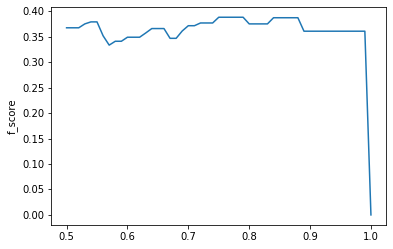

{'accuracy': 0.7670454545454546,
 'precision': 0.3611111111111111,
 'recall': 0.41935483870967744,
 'f1': 0.3880597014925373}

In [359]:
u_clf_test.find_threshold(user_to_y_test)

In [371]:
user_to_ypred_test = u_clf_test.minimum(1)

In [372]:
user_y_test = []
user_y_pred_test = []
for user_id in user_to_ypred_test:
    user_y_test.append(user_to_y_test[user_id])
    user_y_pred_test.append(user_to_ypred_test[user_id])

In [373]:
u_clf_test.get_metrics(user_y_test, user_y_pred_test)

{'accuracy': 0.23863636363636365,
 'precision': 0.16774193548387098,
 'recall': 0.8387096774193549,
 'f1': 0.2795698924731183}